## Access Satellite GHRSST L3S 1day Day and Night Single Sensor Australia data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia dataset available as a [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a136eee7-a990-4c06-a4f6-915657a2464e).

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 31ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

In [4]:
# remote zarr dataset
aodn = GetAodn()
dname = f'{dataset_name}.zarr'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 479 ms, sys: 47.6 ms, total: 526 ms
Wall time: 1.02 s


## Plot time coverage

In [5]:
aodn_dataset.get_temporal_extent()

(Timestamp('1992-03-21 09:20:00'), Timestamp('2024-11-08 09:20:00'))

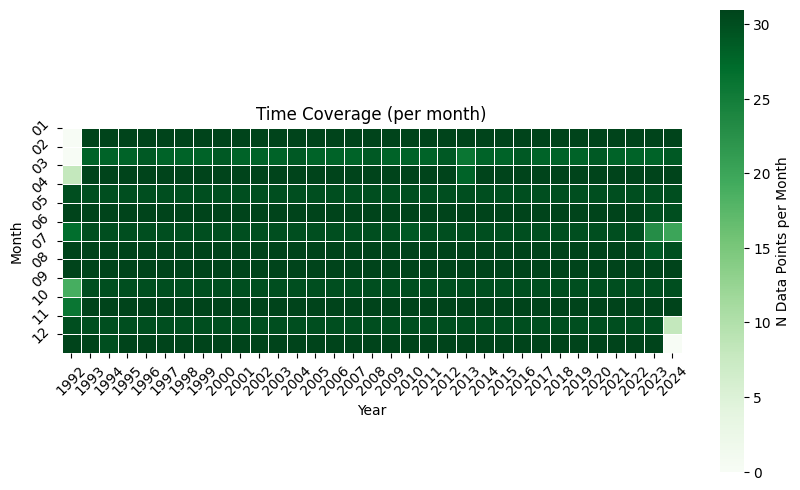

In [6]:
aodn_dataset.plot_time_coverage()

## Timeseries at a point

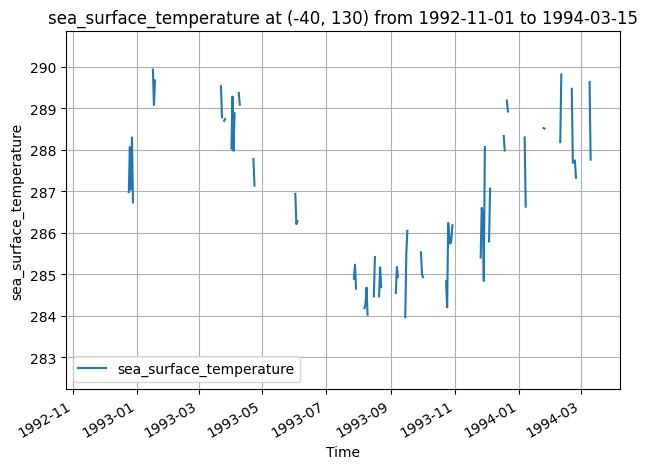

CPU times: user 1.7 s, sys: 416 ms, total: 2.12 s
Wall time: 6.16 s


In [7]:
%%time
time_series_df = aodn_dataset.get_timeseries_data(var_name='sea_surface_temperature', 
                                                  lat=-40, 
                                                  lon=130, 
                                                  date_start='1992-11-01', 
                                                  date_end='1994-03-15', 
                                                  lon_name_override="lon", 
                                                  lat_name_override="lat").plot_timeseries()

## Plot a gridded variable

2025-06-11 16:55:08,074 - aodn.GetAodn - INFO - Plotting 'sea surface foundation temperature' for 9 time steps.
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2510: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(


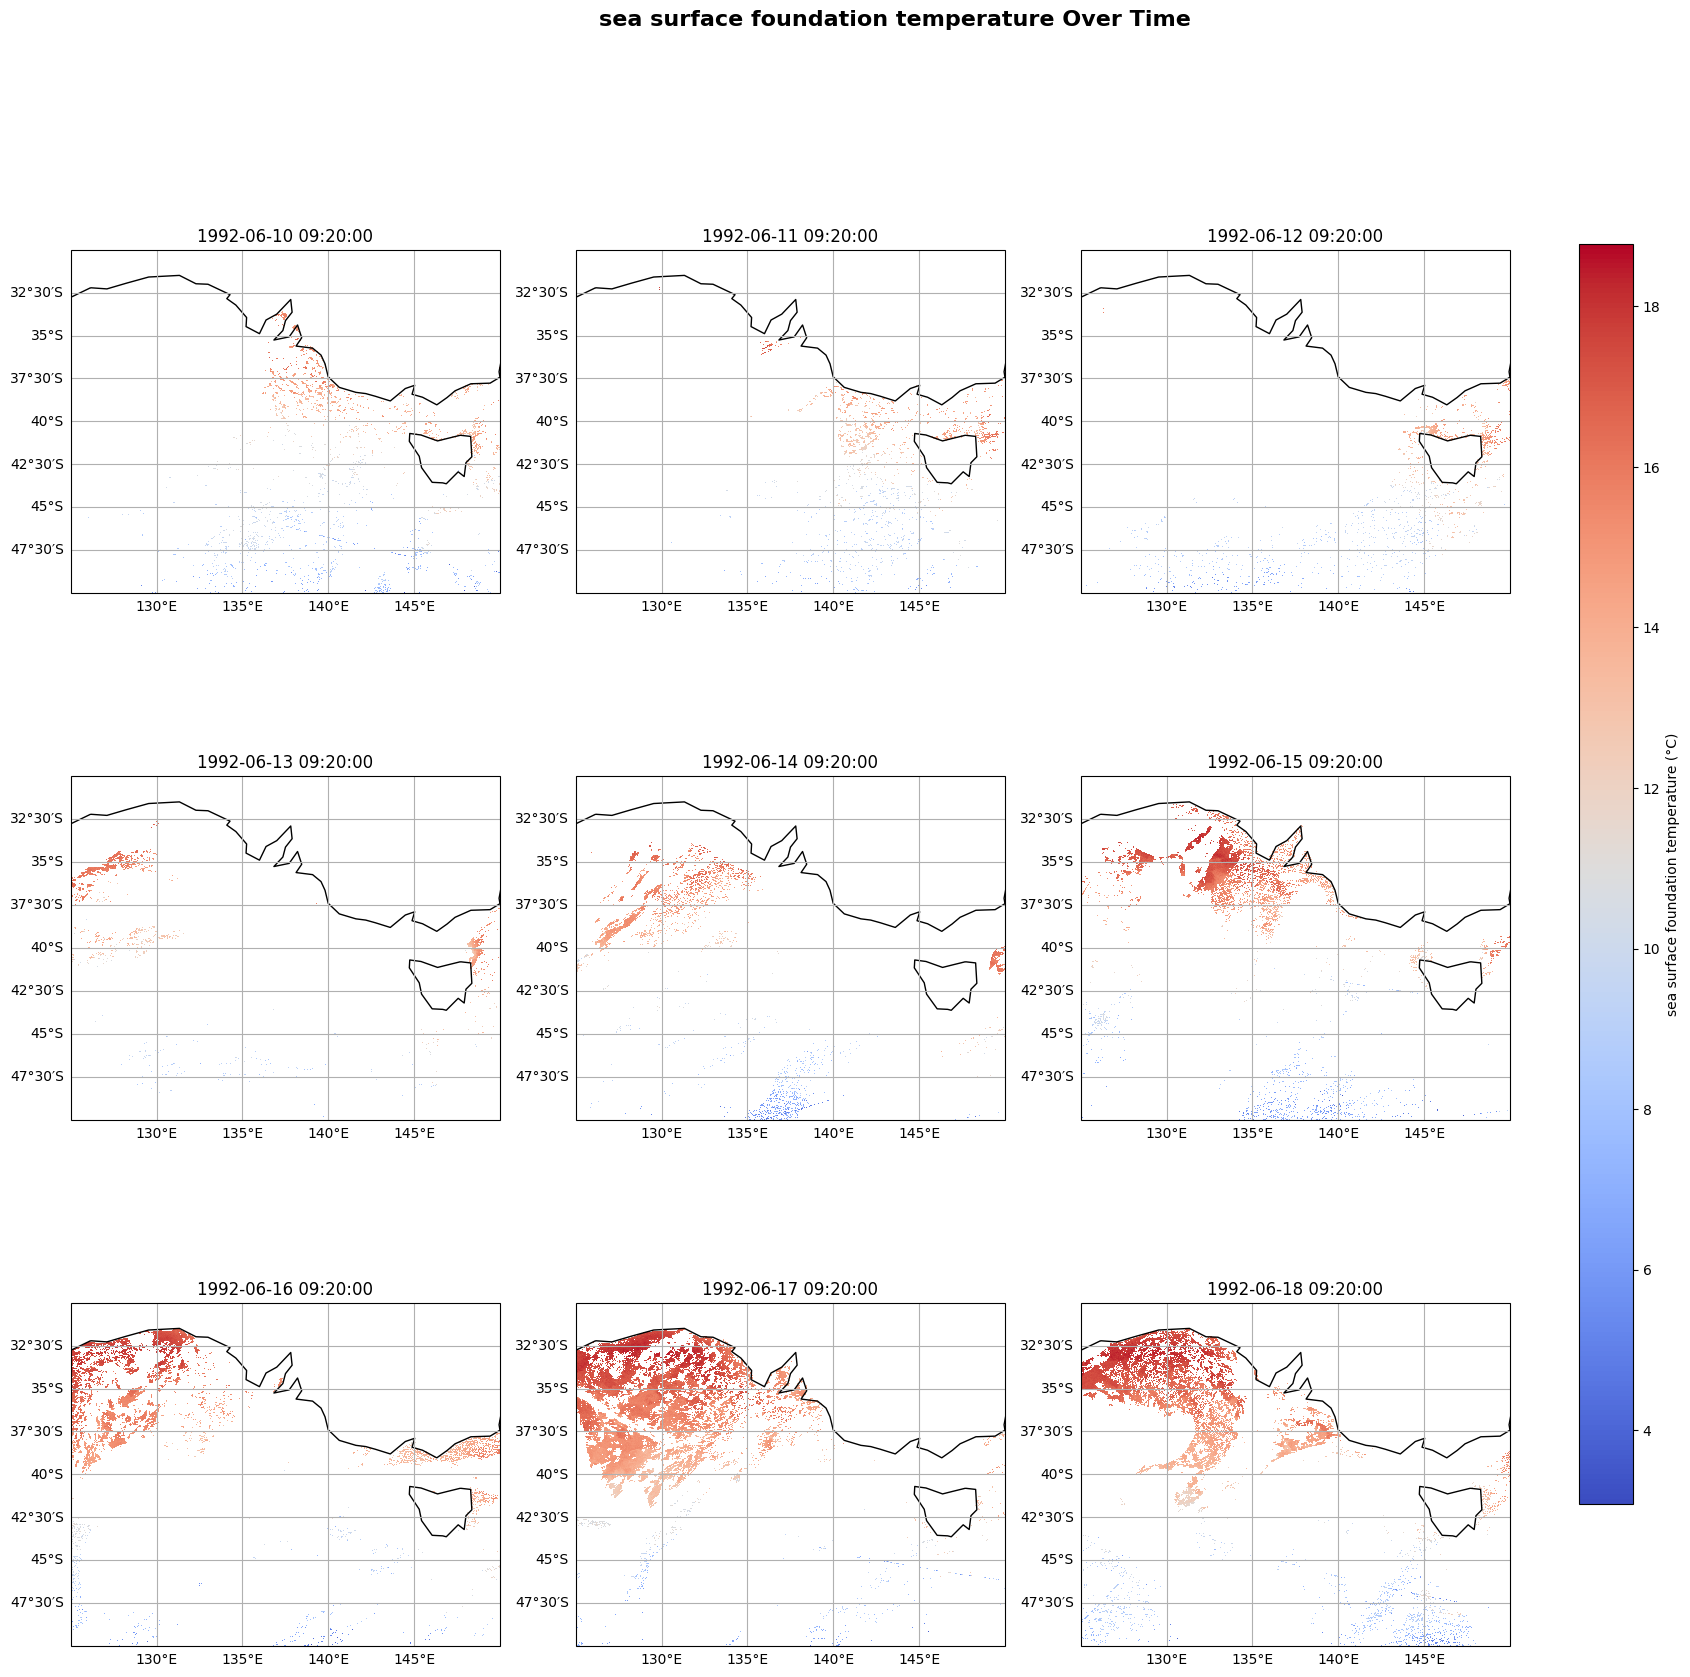

CPU times: user 6.34 s, sys: 5.15 s, total: 11.5 s
Wall time: 7.89 s


In [8]:
%%time
time_series_df = aodn_dataset.plot_gridded_variable(var_name='sea_surface_temperature', 
                                                    date_start='1992-06-10',                                                
                                                    lon_name_override="lon", 
                                                    lat_name_override="lat", 
                                                    lon_slice=(125, 150), 
                                                    lat_slice=(-50, -30), 
                                                    n_days=9, 
                                                    coastline_resolution="110m", 
                                                    log_scale=False)